In [1]:
from coffea import hist
import math
from time import process_time
import os
import psutil
import uproot
import awkward as ak
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

In [ ]:
#Creates array of ecal layer widths and positions. The layer number is the index to the respective values.
    layerZs=np.zeros(34)
    layerSpacing=np.zeros(34)
    layerSpacing[0]=10.0
    #Populates layerZs and layerSpacing
    for evt1, evt2 in zip(ecal_simhit.layer[ecalPath], ecal_simhit.z[ecalPath]):
        #In case the event starts with a layer that has not been indexed yet, use the average layer
        #prevLayer=evt1
        for hit1, hit2 in zip(evt1, evt2):
            #layerZs
            if layerZs[hit1]==0: layerZs[hit1]=hit2
            #layerSpacing
            if layerSpacing[hit1]==0 and layerZs[hit1-1]!=0: layerSpacing[hit1]=hit2-layerZs[hit1-1]
            #Break if lists are done being filled
            if layerSpacing[33]!=0: break    
        if layerSpacing[33]!=0: break
            
    #Creates 2D array of layer widths, with same shape as ecal_simhit.edep, to calculate dE/dz
    WidthMap=[]
    for evt in ecal_simhit.layer:
        evtMask=[]
        for hit in evt:
            evtMask.append(layerSpacing[hit])
        WidthMap.append(evtMask)
    
    WidthMap=ak.Array(WidthMap)

In [17]:
##############################################################################################################
################################### MESSING AROUND WITH AK ARRAYS ############################################
##############################################################################################################

from time import process_time

ed=list(np.zeros((10, 10)))
for i in range(0, 10):
    ed[i]=np.linspace(i+0,i+0.9,10)

    
lay=list(np.zeros((10, 10)))
for i in range(0, 10):
    lay[i]=np.linspace(0,9,10)
    
ed.append(None)
lay.append(None)
#ed.append([])
#lay.append([])


simhits=ak.zip({"edep": ed, "layer": lay})
print(simhits.edep[:, -1])
'''
mask0=simhits.edep<0.5
mask1=ak.num(simhits.edep)>0
mask2=[True, False, False, False, False, False, False, False, False, True, True, False]
simhit0=ak.mask
simhitNone=ak.mask(simhits, mask1)
print(simhitNone.edep)
print(simhitNone[mask2].edep)
print(ak.broadcast_arrays(ak.Array([13, 14, 15]), simhitNone[mask2].edep)[0])



noEmpties=[True if len(x)!=0 else False for x in simhits]
noEmpties=simhits[noEmpties]

#print(ak.sum(noEmpties.edep, axis=1))
layers=[]
counter=0
for i in simhits:
    mx=(max(i.edep, default=-2))
    for j in i:
        if j.edep==mx: layers.append(j.layer)
    counter+=1   
    

#print(layers)

#print(max([], default=-3))
'''

[0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9, None]


'\nmask0=simhits.edep<0.5\nmask1=ak.num(simhits.edep)>0\nmask2=[True, False, False, False, False, False, False, False, False, True, True, False]\nsimhit0=ak.mask\nsimhitNone=ak.mask(simhits, mask1)\nprint(simhitNone.edep)\nprint(simhitNone[mask2].edep)\nprint(ak.broadcast_arrays(ak.Array([13, 14, 15]), simhitNone[mask2].edep)[0])\n\n\n\nnoEmpties=[True if len(x)!=0 else False for x in simhits]\nnoEmpties=simhits[noEmpties]\n\n#print(ak.sum(noEmpties.edep, axis=1))\nlayers=[]\ncounter=0\nfor i in simhits:\n    mx=(max(i.edep, default=-2))\n    for j in i:\n        if j.edep==mx: layers.append(j.layer)\n    counter+=1   \n    \n\n#print(layers)\n\n#print(max([], default=-3))\n'

In [ ]:
start=process_time()
        ##########
        noEmpties=[True if len(x)!=0 else False for x in recoil_simhit.edep[totalMask]]
        noEmpties=recoil_simhit[noEmpties]
        ##########
        stop=process_time()
        print("noEmpties:", stop-start) 
        
        start=process_time()
        #Fills Energy Sum and Energy Average
        edepSum=ak.flatten(ak.sum(noEmpties.edep, axis=1), axis=None)
        edepAvg=ak.flatten(ak.mean(noEmpties.edep, axis=1), axis=None)
        
        histsAdd["recoil_sumEdep"].fill(particle=par, e=edepSum, s=i)
        histsAdd["recoil_avgEdep"].fill(particle=par, e=edepAvg, s=i)
        stop=process_time()
        print("avgSumRecoil:", stop-start) 
        
        start=process_time()
        #Fills Shower Max
        showerMax=np.zeros(len(noEmpties))
        spot=0
        for evt in noEmpties:
            mx=max(evt.edep)
            for hit in evt:
                if hit.edep==mx: showerMax[spot]=(hit.layer)
            spot+=1
        
        histsAdd["recoil_showerMax"].fill(particle=par, e=showerMax, s=i)
        
        ##########
        noEmptiesOneD=[True if len(x)!=0 else False for x in recoil_simhit.edep[totalMask]]
        MaskedAll=recoil_simhit[totalMask]
        noEmpties=MaskedAll[noEmptiesOneD]
        ##########
#------------------------------------------------------------------------------------------------------------
        #Fills hitShowerMax
        positionMax=list([0])*(ak.num(noEmpties.dedz, axis=0))
        
        Last=ak.zip({"x":ak.flatten(ak.max(noEmpties.x, axis=1), axis=None), "y":ak.flatten(ak.max(noEmpties.y, axis=1), axis=None), "z":ak.flatten(ak.max(noEmpties.z, axis=1), axis=None)})
        positionLast=np.zeros(ak.count(noEmpties.dedz, axis=None))
        
        ev=0
        for evt in noEmpties:
            spot=0
            shws=[0]*len(evt)
            
            shwmx=showerXYZ[ev]
            laymx=Last[ev]
            for hit in evt:
                distanceMax=np.sqrt((hit.x-shwmx[0])**2+(hit.y-shwmx[1])**2+(hit.z-shwmx[2])**2)
                if distanceMax==0:
                    distanceMax=1
                if hit.z<shwmx[2]: distanceMax=-distanceMax
                shws[spot]=distanceMax

                spot+=1
            positionMax[ev]=shws
            ev+=1
        
        positionMax=ak.Array(positionMax)
        sumShower=ak.sum(noEmpties.dedz/positionMax, axis=1)
        
        histsAdd["ecalRec_hitShowerMax"].fill(particle=par, e=sumShower, s=i)

In [ ]:
def aa(arrsize):
    arr=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    counter=arrsize
    for i in np.arange(0, arrsize):
        
        n=arrsize-counter
        up=((n+1)*arrsize-(n*(n+1))//2)*2
        lo=up-counter*2
        arr[lo:up]=[1, 0]*(arrsize-i)
        counter-=1
        

        

In [ ]:
#------------------------------------------------------------------------------------------------------
#----------------------------------ROC Curves----------------------------------------------------------
#------------------------------------------------------------------------------------------------------
from sklearn import metrics


dedzRange=np.arange(0,0.2,0.002)
kineRange=range(100,2000,19)

piondedz=histsAdd['E/z'].values()[('Pion',)]
protondedz=histsAdd['E/z'].values()[('Proton',)]


#Note to self: histogram 2d array will be weights, the proton/pion dictionaries will be easy to generate into test sets
#for a hypothesis that is simply (above cutoff dedz=proton). 
#
#Choose a threshold  from range(lower to upper), generate the dataset for that range (cut the propio merge at that threshold)
#calculate the probability for a proton from the actual data set(sum(targetWeights_pro)/sum(merge(targetWeights_pro and _pio)))
#broadcast probability to dataset. Run metrics.roc_curve with y_true as the "dataset" and the broadcast probability as the
#y_score, and sample_weights=targetWeights
#Creates y_true binary array
def parLabel(arr, pdgID):
    return [pdgID for x in arr]

def merge(arr1, arr2):
    return np.append(arr1, arr2, axis=-1)
    

#Generates ROC curves given histogram 2d arrays for proton and pion.
def ROCKdat(proton, pion, lower, upper):
    arrsize=len(proton)
    bigtrue=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    bigscore=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    bigweights=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    step=upper/arrsize
    
    proWeights=proton
    pioWeights=pion
    proLabels=parLabel(proton, 2212)
    pioLabels=parLabel(pion, 211)
    
    #Used for determining array indices
    counter=arrsize
    for i in np.arange(0, arrsize):
        y_true=merge(proLabels[i:],pioLabels[i:])
        proton_prob=np.sum(proWeights[i:])/(np.sum(proWeights[i:])+np.sum(pioWeights[i:]))
        y_score=[proton_prob]*(arrsize-i)*2
        weights=merge(proWeights[i:], pioWeights[i:])
        
        n=arrsize-counter
        up=((n+1)*arrsize-(n*(n+1))//2)*2
        lo=up-counter*2
        bigtrue[lo:up]=y_true
        bigscore[lo:up]=y_score
        bigweights[lo:up]=weights
        counter-=1
        
    print(bigtrue)
    return bigtrue, bigscore, bigweights
                                            
#ytru, ysco, weig= ROCKdat(protondedz, piondedz, 0, 0.30)
#fpr, tpr, thresholds=metrics.roc_curve(ytru, ysco, pos_label=2212, sample_weight=weig)





In [12]:
#print(ak.Array([0.1,0.3,0.5])/ak.Array([1, 3, None]))
arr=ak.Array([[1], [3], []])
recFinal= ak.mask(arr, ak.num(arr)>0)
ecalFinal=ak.Array([[0.1], [0.3], [0.5]])
eOverP= ecalFinal-recFinal
print(eOverP)

[[-0.9], [-2.7], None]


[[0], [0.1], [0.2], [0.3], [0.4], [0.5], [0.6], [0.7], [0.8], [0.9]]
[0.58509705 0.74041365 0.85818695 0.93124292 0.96448658 0.96448658
 0.93124292 0.85818695 0.74041365 0.58509705]
[0.58509705 0.74041365 0.85818695 0.93124292 0.96448658 0.96448658
 0.93124292 0.85818695 0.74041365 0.58509705]
[0.58509705 0.74041365 0.85818695 0.93124292 0.96448658 0.96448658
 0.93124292 0.85818695 0.74041365 0.58509705]
[0.58509705 0.74041365 0.85818695 0.93124292 0.96448658 0.96448658
 0.93124292 0.85818695 0.74041365 0.58509705]
[0.58509705 0.74041365 0.85818695 0.93124292 0.96448658 0.96448658
 0.93124292 0.85818695 0.74041365 0.58509705]
[0.58509705 0.74041365 0.85818695 0.93124292 0.96448658 0.96448658
 0.93124292 0.85818695 0.74041365 0.58509705]
[0.58509705 0.74041365 0.85818695 0.93124292 0.96448658 0.96448658
 0.93124292 0.85818695 0.74041365 0.58509705]
[0.58509705 0.74041365 0.85818695 0.93124292 0.96448658 0.96448658
 0.93124292 0.85818695 0.74041365 0.58509705]
[0.58509705 0.74041365 0.85

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

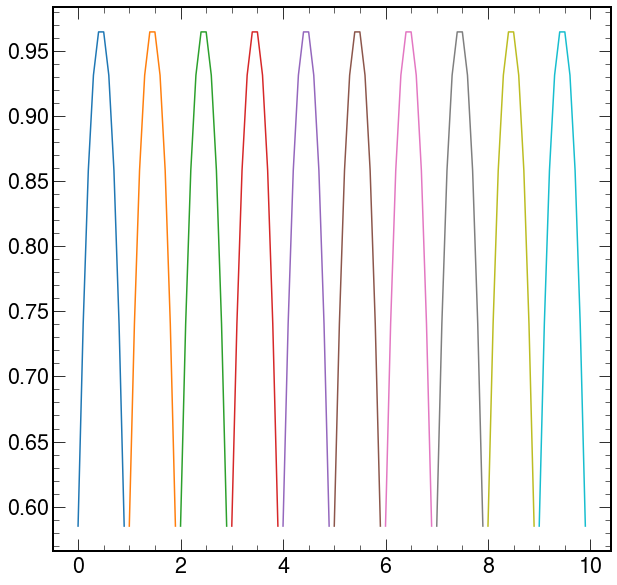

In [93]:

ed=list(np.zeros((10, 10)))
for i in range(0, 10):
    ed[i]=np.linspace(i+0,i+0.9,10)

    
lay=list(np.zeros((10, 10)))
for i in range(0, 10):
    lay[i]=np.linspace(0,9,10)
    
#ed.append(None)
#lay.append(None)
ed.append([])
lay.append([])

simhits=ak.zip({"edep": ed, "layer": lay})
print(simhits.edep[0][:, None])
#print(ak.to_list(simhits.edep[:, :, np.newaxis]))
fig, ax = plt.subplots()

match=np.zeros(len(simhits.edep))
spot=0
for evt in simhits:
    kde = KernelDensity(kernel='gaussian', bandwidth=best).fit(evt.edep[:, np.newaxis])
    dens = np.exp(kde.score_samples(evt.edep[:, np.newaxis]))
    mostLikely=max(dens)
    for i in range(len(dens)):
        if dens[i]==mostLikely: 
            match[spot]=evt.edep[i]
            break
    spot+=1
    print(dens)
    ax.plot(evt.edep, dens)
    
print(match)

'''
if len(evt)
    bandwidths =np.linspace(0.2, 2, 100)
    grid = GridSearchCV(KernelDensity(kernel=kernel),
                    {'bandwidth': bandwidths},
                    cv=5)
    bndwth=grid.fit(evt.edep[:, None])
    best=bndwth.best_params_['bandwidth']
    print(best)
    
    
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(simhits.edep[:, :, np.newaxis])
print(kde.get_params())
scores = kde.score_samples(simhits.edep)
print(scores)
'''

In [16]:
edep=0
layer=0

with uproot.open("data/protonpion_Oct5/ntuple_gps_proton_100.00-2000.00MeV_50k_target_events_r0007_b2_104.root") as file:
    edep=file["Events"]["Ecal_RecHit_e"].array()[0:]
    layer=file["Events"]["Ecal_RecHit_layer"].array()[0:]
    kine=ak.broadcast_arrays(file["Events"]["Sim_Particle_kine"].array()[0:,0], edep)[0]

simhits=ak.zip({'edep':edep, 'layer':layer, 'kine':kine})

#'''
ecalRecWidths=[2.5,1.5,1.25,3,2.75,4.5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,8.5,7,8.5,7,8.5,7,8.5,7,8.5,7]
widthMap=[[ecalRecWidths[hit] for hit in evt] for evt in simhits.layer]
widthMap=ak.Array(widthMap)
simhits["edep"]=simhits.edep/widthMap
#'''


simhits=simhits[simhits.edep>=0.13]
simhits=ak.mask(simhits, ak.num(simhits, axis=1)>0)
#print(simhits.edep[0:100])

#print(ak.to_layout(simhits))


#'''
mx=ak.max(ak.num(simhits.edep, axis=1))
index=0
for i in range(len(simhits.edep)):
    if ak.num(simhits, axis=1)[i]==mx: index=i

print(len(simhits.edep[index]))
print(index)
#print(simhits.edep[index, 0:5])
#print(ak.type(simhits.edep))
#'''

64
39469


-inf
4.605978426931


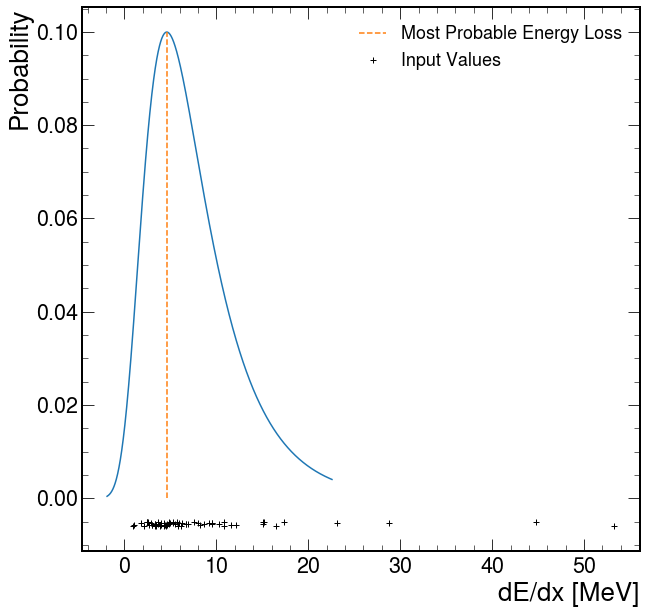

In [20]:
from scipy.stats import moyal
moyal.badvalue=np.nan
print(moyal.a)

x = np.linspace(moyal.ppf(0.01),
                moyal.ppf(0.99999), 1000)
X=simhits.edep[index]

moy=moyal.fit(X)
print(moyal.fit(X)[0])

fig, ax=plt.subplots(figsize=(10,10))
ax.plot(x, moyal.pdf(x, *moy))
ax.plot([moy[0], moy[0]], [0,0.1], "--", label="Most Probable Energy Loss")

#ax.plot(X_plot[:, 0], dens, label= "Kernel Density")
#ax.plot([X[mpel], X[mpel]], [0, xdens[mpel]], "--", label="Most Probable Energy Loss")
ax.plot(X, -0.005 - 0.001 * np.random.random(len(X)), "+k", label= "Input Values")
ax.set_xlabel("dE/dx [MeV]")
ax.set_ylabel("Probability")
ax.legend(loc='upper right', fontsize=18)

In [126]:
print(1==None)
print(ak.Array([s if ak.num(s, axis=0)!=0 else None for s in ak.singletons([[1, 2, 3], None, None])]))
#print(ak.Array([4 if ak.count(s, axis=None)==None else 5 for s in [[1, 2, 3], None, None]]))
print(ak.singletons([[1, 2, 3], None, None]))

False
[[[1, 2, 3]], None, None]
[[[1, 2, 3]], [], []]


In [112]:
# Moyal distribution
from scipy.stats import moyal
'''
x = np.linspace(moyal.ppf(0.01),
                moyal.ppf(0.99), 100)
X=simhits.edep[index]
moy=moyal.fit(X)
print(moyal.fit(X)[0])
plt.plot(x, moyal.pdf(x, *moy))
plt.plot([moy[0], moy[0]], [0,0.5],)
'''
def moymoy(arr):
    if ak.any(ak.is_none(arr)):
        print("a")
    else: print("h")
moymoy(ak.singletons([[1,2,3], None]))

holup=[moyal.fit(s)[0] for s in simhits.edep]
print(holup)

import numba as nb
#@nb.guvectorize([(nb.float32[:], nb.float64)], '(n)->()')
#def nbMoy(arr, ret):
#    ret=moyal.fit(arr)[0]

@nb.guvectorize([(nb.float32[:], nb.float64)], '(n)->()')
def test(arr, ret):
    h=0
    for i in range(len(arr)):
        h+=arr[i]
    ret=[h/len(arr)]*len(arr)
    
class moyalFit(ak.Array):
    def fitMoyal(self, axis=1):
        return moyal.fit(self.edep)[0]

def moySauce(arr):
    part = ak.zip({"edep": arr.edep}, with_name="moyalfit")
    ak.behavior["*","moyalfit"]=moyalFit
    
    return part.fitMoyal()

#def mymoy(arr):
#    return moyal.fit(arr)[0]

mostProb=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", r"$\Delta_{p}/dx$ of Event (Ecal Simhit) [MeV]", 100, 0, 1),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

start=process_time()
#moys=ak.Array([moyal.fit(s)[0] for s in simhits.edep])
#moymoy=ak.Array.__array_ufunc__(simhits.edep, mymoy, 'mymoy')
#print(mymoy(simhits.edep))
#moys=mymoy(simhits.edephowt)
#moys=moySauce(simhits)
print(simhits.edep)
#print(ak.to_numpy(ak.pad_none(simhits.edep, 100, axis=1))[0:5])
holder=ak.to_numpy(ak.pad_none(simhits.edep, 100, axis=1))

holder=holder[holder>0]

moys=moyal.fit(ak.to_numpy(ak.pad_none(simhits.edep, 100, axis=1)))[0]


#print(ak.to_layout(moys))
#print(moyal.fit(simhits.edep[1])[0], ak.to_list(moys[0:5, :]))

#mostProb.fill(particle="Proton", e=moys, s=simhits.kine[:, 0])
end=process_time()
print("total time: {}".format(end-start))

a


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [35]:
array=ak.Array([[1.1, 2.2, 3.3], [4.4, 5.5], [6.6, 7.7, 8.8], [9.9]])
layout = ak.operations.convert.to_layout(
        array, allow_record=False, allow_other=False
    )
print(ak.to_list(layout.starts.to_numpy))
#print([i for i in layout.starts])
print()
tmp = ak._util.completely_flatten(layout)
print(tmp)
print()
print([ak.nplike.of(x).max(x) for x in tmp])
print()
a=layout.max(
                axis=1, mask=True, keepdims=False, initial=None
            )
print(a)
b=ak._util.wrap(a, None)
print(a)


AttributeError: 'awkward._ext.Index64' object has no attribute 'to_numpy'

<AxesSubplot:xlabel='Kinetic Energy [MeV]', ylabel='$\\Delta_{p}/dx$ of Event (Ecal Simhit) [MeV]'>

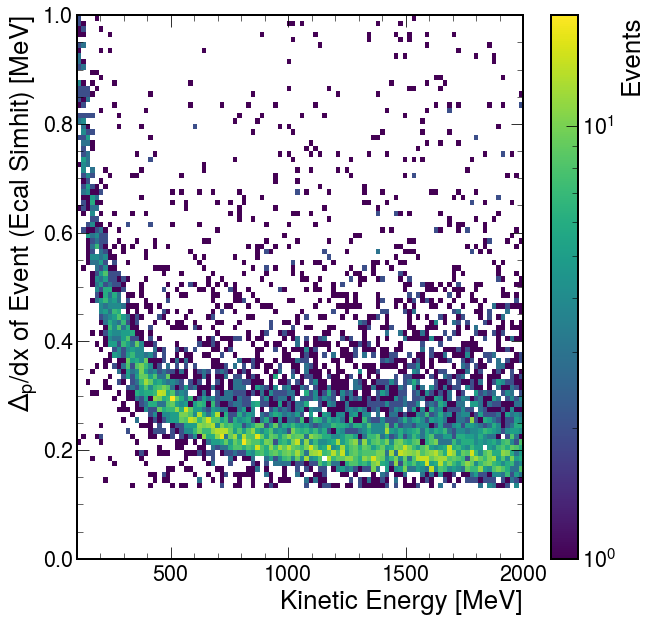

In [68]:
hist.plot2d(mostProb.sum("particle"), "s", clear=True, patch_opts={'norm': colors.LogNorm()})

0.4240165583657093
[0.16420675 0.42401656 0.31690159 0.39388664 0.12217035 0.16069411
 0.05719976 0.08134406 0.3344071  0.30376919 0.3344071  0.06883091
 0.0571965  0.15172101 0.0796975  0.12438577 0.29160101 0.06315233
 0.16156864 0.34398701 0.07561206 0.34275892 0.08613858 0.32721772
 0.14217395 0.34361001 0.32944279 0.06315233 0.38076656 0.1991136
 0.42401656 0.40460246 0.11001765 0.10757825 0.42401656]


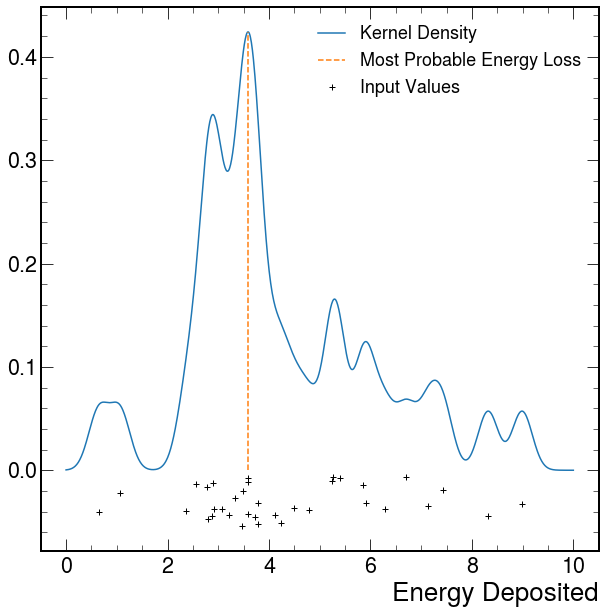

In [12]:
# KDE fitting
X=simhits.edep[index][:, np.newaxis]
X_plot = np.linspace(0, 10, 1000)[:, np.newaxis]

fig, ax=plt.subplots(figsize=(10,10))

kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
dens = np.exp(kde.score_samples(X_plot))
xdens = np.exp(kde.score_samples(X))

mpel=0
print(max(xdens))
print(xdens)
high=max(xdens)
for i in range(len(xdens)):
    if xdens[i]==high:
        mpel=i
        
        

ax.plot(X_plot[:, 0], dens, label= "Kernel Density")
ax.plot([X[mpel], X[mpel]], [0, xdens[mpel]], "--", label="Most Probable Energy Loss")
ax.plot(X[:, 0], -0.005 - 0.05 * np.random.random(len(X[:, 0])), "+k", label= "Input Values")
ax.set_xlabel("Energy Deposited")
ax.legend(loc='upper right', fontsize=18)




In [118]:
bands=[]
def cvBand(arr):
    if len(arr)==1:
        return 1000
    if len(arr)==2:
        return 1000
    elif len(arr)<6:
        cross=len(arr)
    else:
        cross=5
        
    bandwidths =np.linspace(0.1, 3, 30)
    grid = GridSearchCV(KernelDensity(kernel=kernel),
                    {'bandwidth': bandwidths},
                    cv=cross)
    bndwth=grid.fit(arr[:, None])
    best=bndwth.best_params_['bandwidth']
    bands.append(best)
    return best


start=process_time()
match=np.zeros(len(simhits.edep))
spot=0
for evt in simhits:
    best=cvBand(evt.edep)
    if best==1000:
        match[spot]=evt.edep[0]
        spot+=1
        continue
        
    kde = KernelDensity(kernel='gaussian', bandwidth=best).fit(evt.edep[:, np.newaxis])
    dens = np.exp(kde.score_samples(evt.edep[:, np.newaxis]))
    mostLikely=max(dens)
    for i in range(len(dens)):
        if dens[i]==mostLikely: 
            match[spot]=evt.edep[i]
            break
    spot+=1
    
end=process_time()
#18 seconds for 46 samples at 3CV
#38 seconds for 113 samples at 3CV
#60 seconds for 113 samples at 5CV
#
print("Total time for {} samples: {}".format(nsam, (end-start)))

print(bands, max(bands))
print(match)

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf  4.05629632  3.27581163  2.28532273  1.39530491  0.68453167
 -0.09037777 -0.83131554 -1.51778059 -2.15032611 -2.73392475 -3.27417941
 -3.77629408 -4.24482805 -4.68369419 -5.09622967 -5.48528082 -5.85328263
 -6.20232734 -6.5342217  -6.85053396 -7.15263242 -7.44171686 -7.71884436
 -7.98495053 -8.24086702 -8.48733613 -8.72502291 -8.95452542 -9.17638327]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf  0.30912704  0.36448774  0.24869788  0.11807419
 -0.00667401 -0.12175337 -0.22715317 -0.32378347 -0.412

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf -0.693217   -0.64647175
 -0.70899362 -0.73241621 -0.72098895 -0.71896158 -0.75333798 -0.80268017
 -0.8585969  -0.91712935 -0.97623222 -1.03480063 -1.09223038 -1.14819825
 -1.20254426 -1.25520534 -1.30617642 -1.35548707 -1.40318701 -1.44933722
 -1.49400417 -1.5372563  -1.57916178 -1.6197871  -1.65919628 -1.69745039]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf  0.75742349  0.64681914  0.42840101  0.21876495
  0.02902329 -0.14150943 -0.29536901 -0.43508144 -0.562

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf -0.39768355 -0.46842158
 -0.38946806 -0.39910093 -0.45820602 -0.53217059 -0.61032908 -0.68845317
 -0.76471312 -0.83832187 -0.90898533 -0.97665265 -1.04139419 -1.10333884
 -1.16264084 -1.21946206 -1.27396249 -1.32629528 -1.37660447 -1.42502403
 -1.47167781 -1.51667985 -1.56013496 -1.6021394  -1.64278155 -1.68214262]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf  3.34468024  2.59271042  1.67746362  0.87227022
  0.15147586 -0.49230091 -1.07085101 -1.5948178  -2.072

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf -0.20981649 -0.15607988 -0.1802322  -0.17975057
 -0.22133058 -0.30049441 -0.39033223 -0.48165742 -0.57089224 -0.65663142
 -0.73840205 -0.81615172 -0.89001855 -0.96022215 -1.02701036 -1.09063312
 -1.15132983 -1.20932389 -1.26482071 -1.31800767 -1.369055   -1.41811704
 -1.46533367 -1.5108317  -1.55472624 -1.59712191 -1.63811395 -1.67778926]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf -0.30997269  0.03215085  0.0562424  -0.16824465 -0.23646651
 -0.3437354  -0.50592691 -0.68127628 -0.85587627 -1.02456316 -1.18550833
 -1.33827968 -1.48304991 -1.62024639 -1.75038898 -1.87401355 -1.9916364
 -2.10373892 -2.21076222 -2.31310683 -2.4111347  -2.50517226 -2.59551382
 -2.68242484 -2.76614512 -2.84689163 -2.92486102 -3.00023195 -3.07316705]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf  0.71593769  0.56955443  0.37429228  0.19174755
  0.02773111 -0.11922439 -0.25159716 -0.3716828  -0.4813

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf  1.06144255  0.90707124  0.65187514  0.42247259  0.22379406
  0.05070592 -0.1019022  -0.23805058 -0.36078931 -0.47243875 -0.57478731
 -0.66923487 -0.7568941  -0.83866208 -0.91527157 -0.98732828 -1.0553382
 -1.11972816 -1.18086139 -1.2390494  -1.29456135 -1.3476313  -1.39846405
 -1.44723978 -1.49411786 -1.53923988 -1.58273221 -1.6247081  -1.66526944]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -i

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf -1.75210999 -1.64946175 -1.68079377 -1.65974067
 -1.67462238 -1.70086183 -1.7595857  -1.83149355 -1.90914971 -1.98903987
 -2.06930614 -2.14890709 -2.22724435 -2.30397576 -2.37891378 -2.45196697
 -2.52310456 -2.59233445 -2.65968905 -2.72521605

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf -9.55909728 -9.54963666 -9.6812649  -9.74450064 -9.73915271]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf  1.02891055  0.79828891  0.5641994   0.36478907  0.19509605
  0.04847356 -0.08020582 -0.19467763 -0.29767722 -0.391

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf -0.93423946 -0.6311807
 -0.58023351 -0.49169728 -0.49438266 -0.52876352 -0.57602493 -0.62859426
 -0.68293834 -0.73728294 -0.79070952 -0.84274621 -0.89316531 -0.94187645
 -0.98886753 -1.03417094 -1.07784369 -1.11995561 -1.1605822  -1.19980034
 -1.23768573 -1.27431142 -1.309747   -1.34405819 -1.37730674 -1.40955045]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf  0.67902099  0.74997744  0.57393856  0.375063    0.19171826
  0.02749706 -0.11949935 -0.25186307 -0.37192517 -0.48161029 -0.58247387
 -0.67577113 -0.76252093 -0.84355735 -0.91956953 -0.99113214 -1.05872868
 -1.12276926 -1.18360453 -1.24153639 -1.2968265  -1.34970305 -1.40036618
 -1.44899233 -1.49573781 -1.54074174 -1.58412845 -1.62600949 -1.66648532]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf  -2.55577449  -3.05282903  -3.62310

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf -0.01940464  0.25088857  0.18977048  0.08064994
 -0.032874   -0.14123033 -0.24224599 -0.335844   -0.4225702  -0.50311848
 -0.57816981 -0.64834081 -0.7141725  -0.77613367 -0.8346289  -0.89000748
 -0.9425717  -0.99258411 -1.04027371 -1.08584109 -1.12946274 -1.17129456
 -1.21147493 -1.25012706 -1.28736117 -1.32327614 -1.35796104 -1.39149631]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf -0.7796925  -0.66786994 -0.84953358
 -1.1773795  -1.50950545 -1.80812504 -2.12670204 -2.466

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf -1.83704548
 -1.75455998 -1.77414471 -1.79167844 -1.81358715 -1.80976176 -1.82101005
 -1.84895045 -1.88572254 -1.9274931  -1.97212824 -2.01834109 -2.06531471
 -2.11251279 -2.15957572 -2.20625967 -2.25239897

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf  0.07856813  0.16378994  0.0639537
 -0.06023496 -0.1840684  -0.30159937 -0.41151398 -0.51391981 -0.60936983
 -0.69852454 -0.78202987 -0.86047554 -0.93438481 -1.00421628 -1.07037016
 -1.1331955  -1.19299731 -1.25004277 -1.30456681 -1.35677671 -1.40685604
 -1.45496802 -1.50125829 -1.54585726 -1.5888821  -1.63043845 -1.67062183]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf -0.55813334 -0.65366966 -0.80457475 -0.95080341
 -1.08411677 -1.13184683 -1.10069197 -1.05661886 -0.9847

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf  0.81685358  0.98614087  0.8138387   0.56483283  0.2627037
 -0.03064665 -0.3031607  -0.55369643 -0.78391947 -0.99609256 -1.19241667
 -1.37484782 -1.5450693  -1.70451364 -1.85439738 -1.99575569 -2.12947302
 -2.2563088  -2.37691859 -2.49187131 -2.6016633  -2.7067298  -2.80745428
 -2.90417617 -2.99719724 -3.08678682 -3.17318629 -3.25661268 -3.33726186]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -i

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf -0.63894445 -0.48340245
 -0.3821963  -0.38611673 -0.42561341 -0.47914985 -0.53805174 -0.59836976
 -0.65819454 -0.71658847 -0.7731073  -0.82756754 -0.8799265  -0.93021765
 -0.97851473 -1.02491133 -1.06950921 -1.11241157 -1.15371928 -1.19352879
 -1.23193114 -1.26901151 -1.30484924 -1.33951793 -1.37308578 -1.4056159 ]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf        -inf        -inf
        -inf -4.65741652 -4.62819424 -4.74433201 -4.941

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newa

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf -1.58832843
 -1.5332219  -1.54449687 -1.49610044 -1.46088931 -1.42881368 -1.42680533
 -1.43950613 -1.46049195 -1.48646297 -1.51551667 -1.54647366 -1.57856651
 -1.61127891 -1.6442553  -1.67724709 -1.71007884 -1.74262635 -1.77480199]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf        -inf -0.66781196
 -0.70044532 -0.62786402 -0.62709534 -0.68378756 -0.758

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
 -3.97558241 -4.06051992 -4.20975693 -4.39737819 -4.59518014 -4.74225094
 -4.87614307 -4.95340922 -5.07187638 -5.20717432 -5.34894117 -5.49270951
 -5.63622991 -5.77827361 -5.91814328 -6.05544194 -6.18995218 -6.32156816]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf -6.28826208 -6.26135094 -6.350

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf -0.05518248  0.09917842  0.10516649  0.01723268
 -0.11130743 -0.24559944 -0.37594008 -0.49942507 -0.61543844 -0.72419532
 -0.82620253 -0.92204432 -1.01229588 -1.09748998 -1.1781068  -1.25457354
 -1.32726814 -1.39652439 -1.46263722 -1.52586767 -1.58644736 -1.64458237
 -1.70045664 -1.7542348  -1.80606471 -1.85607957 -1.90439967 -1.95113404]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -

Total time for 500 samples: 323.828125
[0.2, 0.4, 1.9, 0.4, 0.2, 0.2, 0.3, 0.4, 0.4, 0.1, 0.1, 0.4, 0.2, 0.4, 0.6, 0.3, 0.1, 0.8999999999999999, 0.2, 0.4, 1.0999999999999999, 0.3, 0.5, 0.4, 0.1, 1.0999999999999999, 0.1, 0.2, 1.4, 1.0999999999999999, 0.7, 0.3, 0.5, 1.4, 0.1, 0.1, 0.4, 0.1, 0.3, 0.3, 2.6, 0.1, 0.1, 0.2, 0.2, 0.1, 0.1, 1.2, 0.3, 0.4, 0.1, 0.1, 0.1, 0.3, 2.0, 0.4, 1.0999999999999999, 1.4, 1.4, 0.4, 0.1, 2.1999999999999997, 1.4, 0.7, 0.4, 0.1, 0.3, 0.9999999999999999, 0.4, 0.1, 0.6, 0.2, 0.1, 0.5, 0.1, 1.0999999999999999, 1.4, 0.7, 0.1, 0.1, 0.4, 0.1, 0.2, 0.6, 0.2, 0.1, 0.1, 0.1, 0.3, 0.4, 0.6, 0.3, 2.0, 0.1, 0.8999999999999999, 0.1, 0.8999999999999999, 0.1, 0.1, 0.3, 0.1, 0.9999999999999999, 0.1, 0.4, 0.6, 1.5, 0.1, 0.4, 2.1999999999999997, 0.1, 0.6, 0.1, 0.1, 0.3, 0.2, 0.9999999999999999, 0.4, 2.6999999999999997, 0.2, 0.3, 0.3, 0.2, 0.2, 0.1, 0.1, 2.9, 0.4, 0.1, 2.0, 2.3, 0.1, 0.3, 0.7999999999999999, 1.8, 0.4, 3.0, 0.3, 0.8999999999999999, 0.3, 1.4, 0.6, 2.0, 0.89999999

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf -1.17073153 -1.04906298
 -1.03155576 -1.07705231 -1.16679381 -1.30677331 -1.47194343 -1.64360488
 -1.81435437 -1.98094655 -2.14196363 -2.29686816 -2.44556694 -2.58819382
 -2.72499587 -2.85627178 -2.98233795 -3.10350987 -3.22009205 -3.33237296
 -3.4406228  -3.54509287 -3.64601593 -3.74360707 -3.83806478 -3.92957218]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:978: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf        -inf        -inf        -inf        -inf
        -inf        -inf -2.35911245 -2.40562932 -2.45214619 -2.49866306
 -2.54517993 -2.5916968  -2.63821367 -2.68473054 -2.73124741 -2.77776428
 -2.82428115 -2.87079802 -2.9173149  -2.96383177 -3.01034864 -2.42125474
 -2.46777161 -2.51428848 -2.56080535 -2.60732222 -2.653

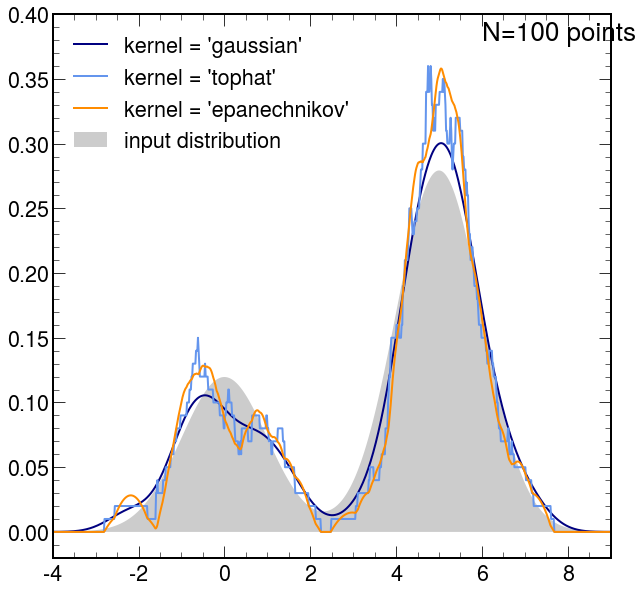

In [125]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.utils.fixes import parse_version



# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]



X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel=kernel),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
    grid.fit(x[:, None]);

    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc="upper left")
#ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

In [7]:
x=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y=np.array([])
#print(x[:, None])
#print(np.logspace(-4, -2, 100))
edep=[1, 2, 3, 4, 5, 6]
lay=[[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]]
#print(ak.broadcast_arrays(edep, lay)[0])
shws=[0, 0, 0, 0]
shws[0]=[1, 2, 3, 4]
shws[1]=[1, 2, 3]
print(shws)

[[1, 2, 3, 4], [1, 2, 3], 0, 0]


In [233]:
@nb.guvectorize([(nb.int64[:], nb.float64)], '(n)->()')
#@nb.jit(forceobj=True)
def g(x, res):
    h=np.array(len(x))
    for i in range(x.shape[0]):
        h[i]=moyal.fit(x[i])[0]
        
    #print(res)
    #for i in range(len(x)):
    #    h.append(x[i] + 10)
    #    res=i+10


a = ak.Array([[0, 1, 2], [3, 4, 5, 6]])
b=g(a)
print("input: ", a,"\noutput:", b)

ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.5.0/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

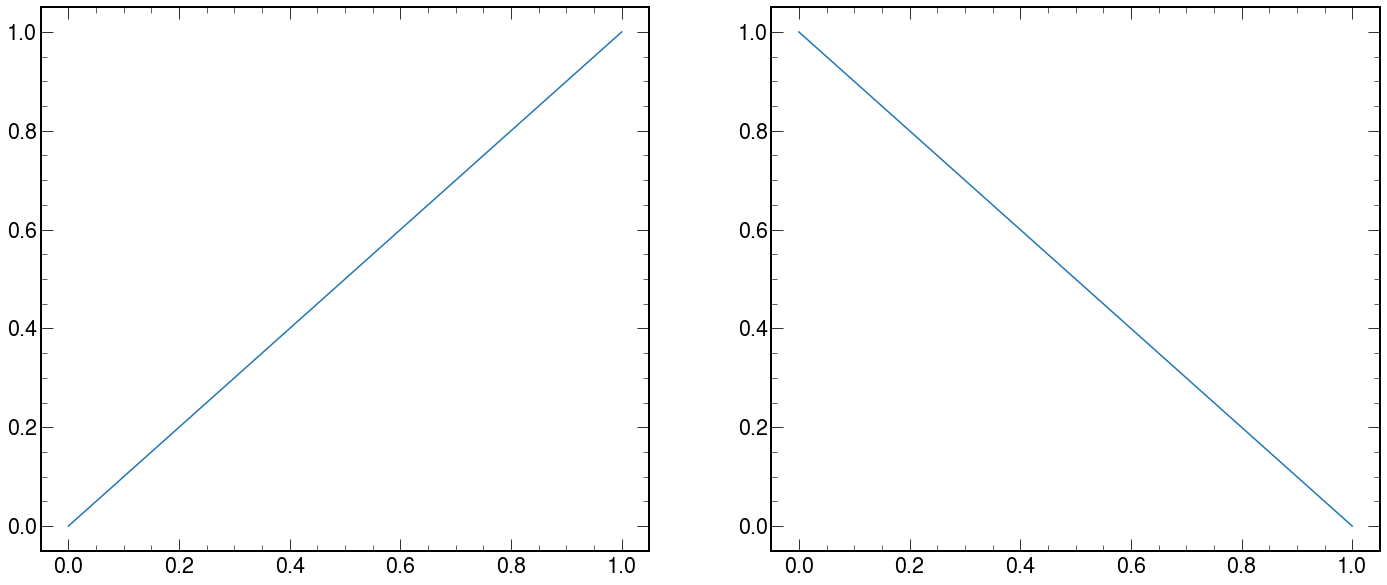

In [6]:
fig, ax=plt.subplots(ncols=2, nrows=1, figsize=(24, 10))
ax[0].plot([0, 1], [0, 1])
ax[1].plot([1,0], [0,1])

[0.     0.     0.0625 0.0625 0.0625 0.25   0.5625 1.    ] [0.  0.4 0.7 0.9 1.  1.  1.  1. ] [1.92 0.92 0.86 0.78 0.5  0.49 0.3  0.2 ]


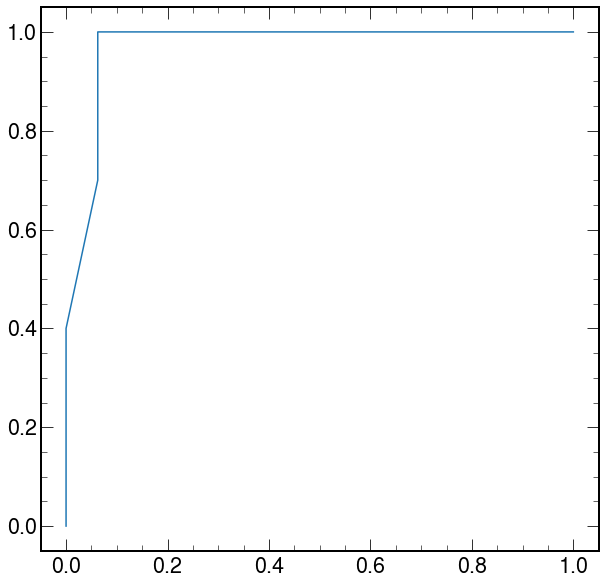

In [69]:
from sklearn.metrics import roc_curve, auc

true=np.array([1, 1, 1, 1, 0, 0, 0, 0])
calcP=np.array([0.92, 0.86, 0.78, 0.5, 0.86, 0.49, 0.3, 0.2])
weights=np.array([8, 6, 4, 2, 1, 3, 5, 7])
#score=1-np.abs(true-calcP)/true
#print(true, score)
fpr, tpr, _=roc_curve(true, calcP, sample_weight=weights)
print(fpr, tpr, _)
plt.plot(fpr, tpr)

Import data
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]


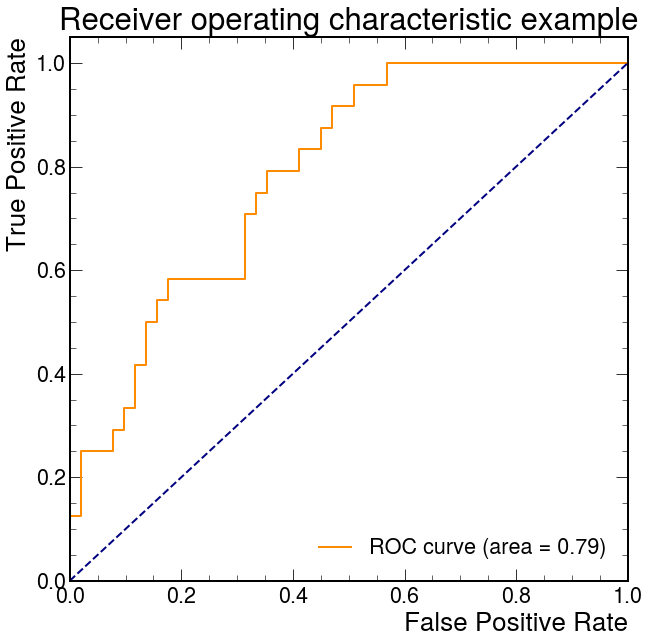

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
print("Import data")
print(X, y)
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
print("Binarize")
print(y, n_classes)

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
print(len(y_test[:, 0]), y_score[:, 0])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

